In [2]:
import cv2
import PIL

import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np

In [11]:
from numba import cuda 
device = cuda.get_current_device()
device.reset()

In [2]:
vgg = tf.keras.applications.VGG19(include_top=True, weights="imagenet")

for layers in vgg.layers:
  print(f"{layers.name} ---> {layers.output_shape}")

input_1 ---> [(None, 224, 224, 3)]
block1_conv1 ---> (None, 224, 224, 64)
block1_conv2 ---> (None, 224, 224, 64)
block1_pool ---> (None, 112, 112, 64)
block2_conv1 ---> (None, 112, 112, 128)
block2_conv2 ---> (None, 112, 112, 128)
block2_pool ---> (None, 56, 56, 128)
block3_conv1 ---> (None, 56, 56, 256)
block3_conv2 ---> (None, 56, 56, 256)
block3_conv3 ---> (None, 56, 56, 256)
block3_conv4 ---> (None, 56, 56, 256)
block3_pool ---> (None, 28, 28, 256)
block4_conv1 ---> (None, 28, 28, 512)
block4_conv2 ---> (None, 28, 28, 512)
block4_conv3 ---> (None, 28, 28, 512)
block4_conv4 ---> (None, 28, 28, 512)
block4_pool ---> (None, 14, 14, 512)
block5_conv1 ---> (None, 14, 14, 512)
block5_conv2 ---> (None, 14, 14, 512)
block5_conv3 ---> (None, 14, 14, 512)
block5_conv4 ---> (None, 14, 14, 512)
block5_pool ---> (None, 7, 7, 512)
flatten ---> (None, 25088)
fc1 ---> (None, 4096)
fc2 ---> (None, 4096)
predictions ---> (None, 1000)


In [3]:
vgg.save_weights("C:\Class\Python\TensorFlow\Expirement\models\Weights.h5")

### Gram Matrix
get the correlation between the filters from the output output of the conv_4d for gettng the styling properties

### ${G^l}_{cd} = \frac{\sum_{ij} F^l_{ijc}(x) F^l_{ijd}(x)}{IJ}$

In [3]:
def gram_matrix(input_tensor):
  result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
  gram_matrix = tf.expand_dims(result, axis=0)
  input_shape = tf.shape(input_tensor)
  i_j = tf.cast(input_shape[1]*input_shape[2], tf.float32)
  return gram_matrix/i_j

In [4]:
def load_vgg():
  vgg = tf.keras.applications.VGG19(include_top=True, weights=None)
  vgg.load_weights('C:\Class\Python\TensorFlow\Expirement\models\Weights.h5')
  vgg.trainable = False
  content_layers = ['block4_conv2']
  style_layers = ['block1_conv1', 'block2_conv1', 'block3_conv1', 'block4_conv1', 'block5_conv1']
  content_output = vgg.get_layer(content_layers[0]).output 
  style_output = [vgg.get_layer(style_layer).output for style_layer in style_layers]
  gram_style_output = [gram_matrix(output_) for output_ in style_output]

  model = tf.keras.Model([vgg.input], [content_output, gram_style_output])
  return model

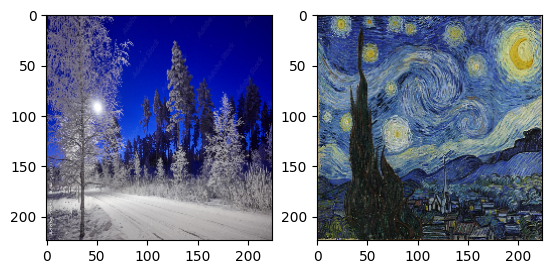

In [169]:
%matplotlib inline

content_image = cv2.resize(cv2.imread('test/Content/winter night.jpg'), (224, 224))
content_image = tf.image.convert_image_dtype(content_image, tf.float32)
style_image = cv2.resize(cv2.imread('test/Style/The Starry NIght.jpg'), (224, 224))
style_image = tf.image.convert_image_dtype(style_image, tf.float32)
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(np.array(content_image), cv2.COLOR_BGR2RGB))
plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(np.array(style_image), cv2.COLOR_BGR2RGB))
plt.show()

In [69]:
opt = tf.optimizers.Adam(learning_rate=0.01, beta_1=0.99, epsilon=1e-1)

### Loss Functions

#### $E_{l} = \frac{1}{4N^2_{l}M^2_{l}} \sum\limits_{i, j}(G^l_{ij} - A^l_{ij})^2$
#### $L_{content}(\vec p, \vec x, l) = \frac{1}{2} \sum\limits_{i, j}(F^l_{ij} - P^l_{ij})^2$
#### $L_{total} = \alpha L_{content}(\vec p, \vec x) + \beta L_{style}(\vec a, \vec x)$

In [162]:
def loss_object(style_outputs, content_outputs, style_target, content_target):
  style_weight = 1e-4
  content_weight = 1e0
  content_loss = tf.reduce_mean((content_outputs - content_target)**2)
  style_loss = tf.add_n([tf.reduce_mean((output_ - target_)**2) for output_, target_ in zip(style_outputs, style_target)])
  total_loss = content_weight*content_loss + style_weight*style_loss
  return total_loss

In [8]:
vgg_model = load_vgg()

In [149]:
content_target = vgg_model(np.array([content_image*255]))[0]
style_target = vgg_model(np.array([style_image*255]))[1]

In [72]:
def train_step(image, epoch):
  with tf.GradientTape() as tape:
    output = vgg_model(image*255)
    loss = loss_object(output[1], output[0], style_target, content_target)
  gradient = tape.gradient(loss, image)
  opt.apply_gradients([(gradient, image)])
  image.assign(tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0))

  if epoch % 100 == 0:
    tf.print(f"Loss = {loss}")

In [163]:
EPOCHS = 1000
image = tf.image.convert_image_dtype(content_image, tf.float32)
image = tf.Variable([image])
for i in range(EPOCHS):
  train_step(image, i)

Loss = 9805750.0
Loss = 967489.6875
Loss = 655470.6875
Loss = 528843.0
Loss = 474479.25
Loss = 447936.3125
Loss = 433134.8125
Loss = 424026.5625
Loss = 418052.03125
Loss = 413877.84375


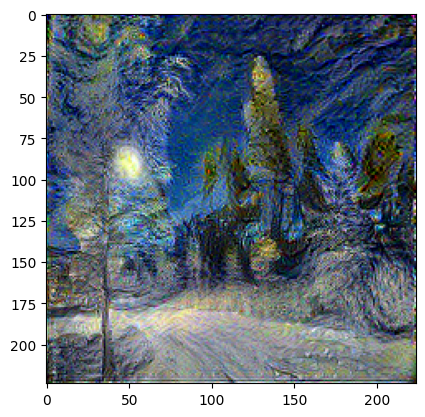

In [175]:
%matplotlib inline
tensor = image*255
tensor = np.array(tensor, dtype=np.uint8)
if np.ndim(tensor)>3:
  assert tensor.shape[0] == 1
  tensor = tensor[0]
tensor =  PIL.Image.fromarray(tensor)
tensor = cv2.cvtColor(np.array(tensor), cv2.COLOR_BGR2RGB)
plt.imshow(tensor)
plt.show()

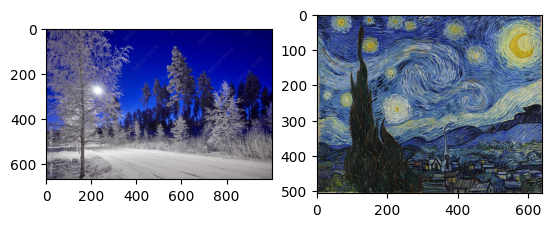

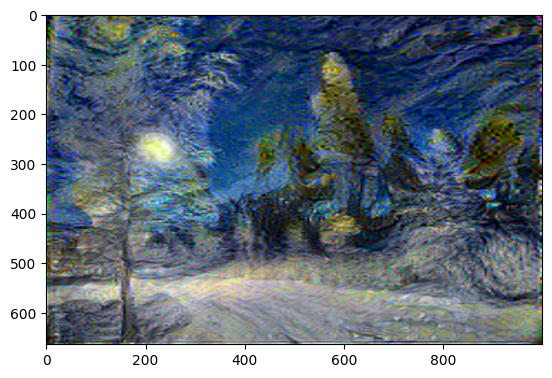

In [176]:
%matplotlib inline
plt.subplot(1, 2 ,1)
plt.imshow(cv2.cvtColor(cv2.imread('test/Content/winter night.jpg'), cv2.COLOR_BGR2RGB))
plt.subplot(1, 2 ,2)
plt.imshow(cv2.cvtColor(cv2.imread('test/Style/The Starry NIght.jpg'), cv2.COLOR_BGR2RGB))
plt.show()
plt.imshow(cv2.resize(tensor, (1000, 664)))